# Impact of correlation between two single-bin distributions

The goal of this notebook is explore the impact of correlation between observables using the most simple case: only two single bins and response "matrices" (which are efficiencies in that case) of $1.0$. The problem, for a given correlation $\rho$ between the two bins, has then the following negative log likelihood:

$$
q_{\rho} \; \equiv \; -2\ln\mathcal{L}_{\rho}(d_0, d_1 | t_0, t_1) \; = \; \begin{pmatrix} d_0 - t_0 & d_1 - t_1 \end{pmatrix} \; \begin{pmatrix}
\sigma^2_0 & \rho \, \sigma_0 \sigma_1 \\
\rho \, \sigma_0 \sigma_1  & \sigma^2_1 
\end{pmatrix}^{-1}
 \begin{pmatrix} d_0 - t_0 \\ d_1 - t_1 \end{pmatrix}
$$
where $\sigma_i = \sqrt{t_1}$. We consider the following numerical values:$d_0 = 90$ and $d_1 = 110$.

## Import, global variables and helper functions

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import json
from scipy import optimize
import umodel as unf

import matplotlib as mpl
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['legend.fontsize'] = 'xx-large'
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['figure.figsize'] = (10, 7)

# Number of bins per distribution
nBins = 1

# Observed data in each bin.
Ds = [np.array([90]*nBins), np.array([110]*nBins)]
Rs = [np.eye(nBins), np.eye(nBins)]

# Return the correlation matrix for a given rho
def corrMatrix(rho): 
    c = np.eye(2*nBins)                                                      
    for i in range(0, nBins):                                                    
        for j in range(0, nBins):                                                
            if i == j:                                                           
                c[i+nBins, j] = rho 
                c[i, j+nBins] = rho
    return c 

## Comparison of profiled NLL for different  correlation $\rho$

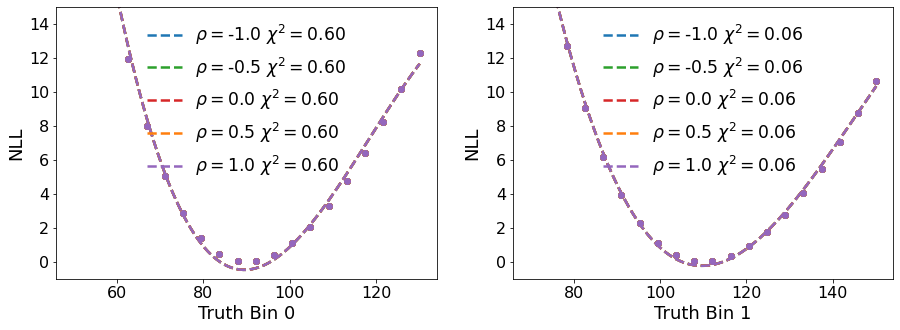

In [14]:
# Compare profiled NLL for different correlation values
colors = ['tab:blue', 'tab:green', 'tab:red', 'tab:orange', 'tab:purple'] * 10
plt.figure(figsize=(15, 5))

# Bin 0
plt.subplot(1, 2, 1)
for r, c in zip(np.linspace(-1, 1, 5), colors):
    m = unf.model(Ds, Rs, corrMatrix(r))
    m.plotProfile(0, 50, 130, 20, label='$\\rho=$' + '{:.1f}'.format(r), color=c)
plt.xlabel('Truth Bin 0')
plt.ylabel('NLL')
plt.ylim(-1, 15)
    
# Bin 1
plt.subplot(1, 2, 2)
for r, c in zip(np.linspace(-1, 1, 5), colors):
    m = unf.model(Ds, Rs, corrMatrix(r))
    m.plotProfile(1, 70, 150, 20, label='$\\rho=$' + '{:.1f}'.format(r), color=c)
plt.xlabel('Truth Bin 1')
plt.ylabel('NLL')
plt.ylim(-1, 15);

## Uncertainty on $t_i$ as function of $\rho$

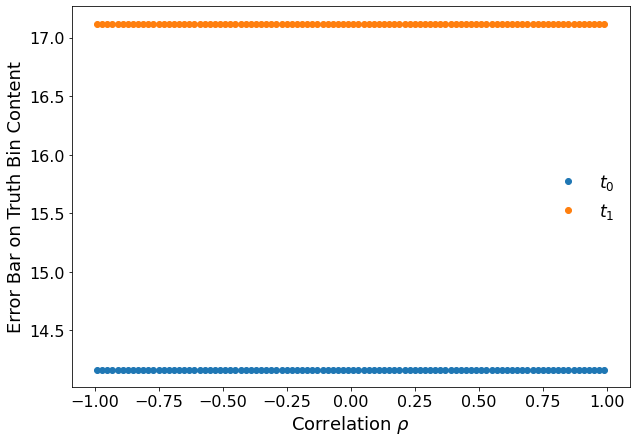

In [33]:
# Performing profiling for different value of rho
t0err, t1err = [], []
rs = np.linspace(-.99, +0.99, 100)
for r in rs:                                                 
    m = unf.model(Ds, Rs, corrMatrix(r))                                         
    ts = m.postFitUncerPOIs(chi2Tol=5)
    t0err.append(ts[0][0][2] + ts[0][0][1])
    t1err.append(ts[1][0][2] + ts[1][0][1])

# Error bar size (coming from profiled NLL) vs rho
plt.plot(rs, t0err, 'o', label='$t_0$')
plt.plot(rs, t1err, 'o', label='$t_1$')
plt.xlabel('Correlation $\\rho$')
plt.ylabel('Error Bar on Truth Bin Content')
plt.legend();

## NLL evolution with $\rho$

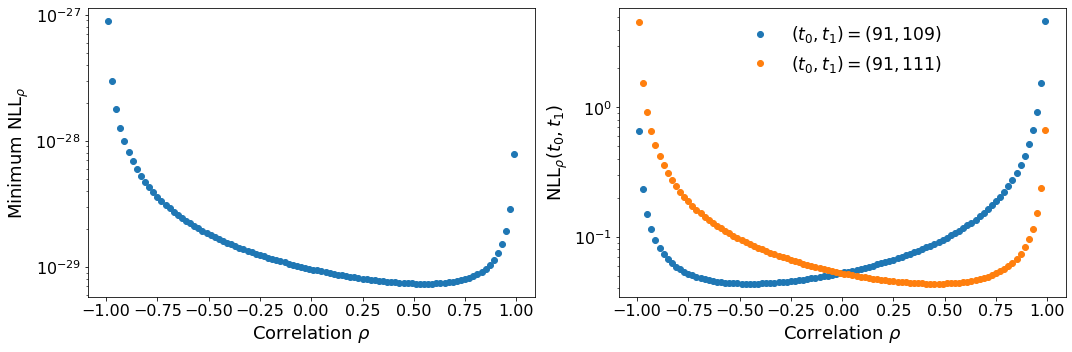

In [38]:
nll0s, nll1s, nll2s = [], [], []
b1min, b2min = [], []
rs = np.linspace(-.99, +0.99, 100)
for r in rs:                                                 
    m = unf.model(Ds, Rs, corrMatrix(r))                                         
    _, nll = m.unfold()
    nll0s.append(nll)
    nll1s.append(m.NLL([[92], [109]]))
    nll2s.append(m.NLL([[92], [111]]))

# Minimum NLL vs rho
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.semilogy(rs, nll0s, 'o')
plt.xlabel('Correlation $\\rho$')
plt.ylabel('Minimum NLL$_{\\rho}$')

# NLL(t0=d0, t1=d1) vs rho
plt.subplot(1, 2, 2)
plt.semilogy(rs, nll1s, 'o', label='$(t_0, t_1) = (91, 109)$')
plt.semilogy(rs, nll2s, 'o', label='$(t_0, t_1) = (91, 111)$')
plt.xlabel('Correlation $\\rho$')
plt.ylabel('NLL$_{\\rho}(t_0, t_1)$');
plt.legend()

plt.tight_layout()

## Building the profiled NLL by hand

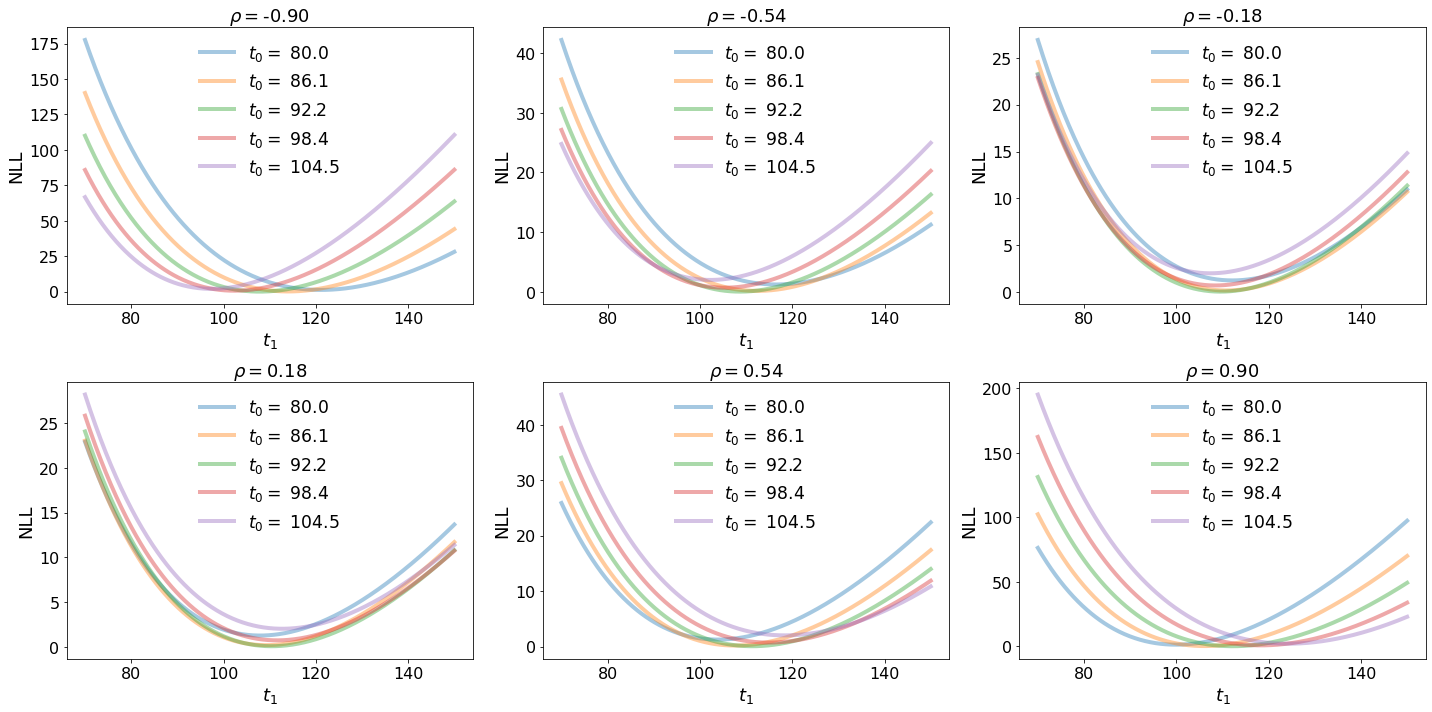

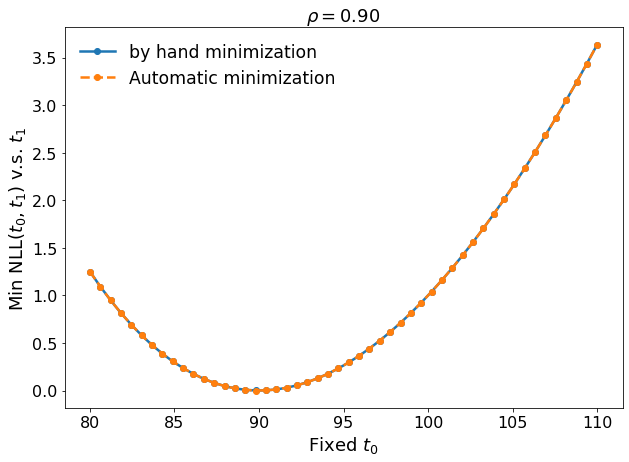

In [120]:
t0s = np.linspace(80, 110, 50)
t1s = np.linspace(70, 150, 500)
rs  = np.linspace(-0.9, 0.9, 6)
plt.figure(figsize=(20, 10))

# Loop over correlation values
for ir, r in enumerate(rs):
    m = unf.model(Ds, Rs, corrMatrix(r))
    t1sFit, nllsMin, nllsMin2 = [], [], []
    
    # Go on the relevant subplot
    plt.subplot(2, 3, ir+1)
    
    # Loop over t0 value
    for it, t0 in enumerate(t0s):
        
        # Manual minimization
        nlls = []
        for t1 in t1s:
            nlls.append(m.NLL([[t0], [t1]]))
        nllsMin2.append(np.min(np.array(nlls)))
        
        # Automatic minimization
        res = m.minimizeNLL(iPOI=0, vPOI=t0)
        t1sFit.append(res.x[0])
        nllsMin.append(res.fun)
        
        # Plot results for this correlation value
        if it%10 == 0:
            plt.plot(t1s, nlls, label='$t_0 =$ ' + '{:.1f}'.format(t0), linewidth=4, alpha=0.4)

    # Plot cosmetics
    plt.gca().set_title('$\\rho = $' + '{:.2f}'.format(r))
    plt.xlabel('$t_1$')
    plt.ylabel('NLL')
    plt.legend()

plt.tight_layout()

# Compare manual minimization and automatic one
plt.figure()
plt.plot(t0s, nllsMin2, 'o-', label='by hand minimization')
plt.plot(t0s, nllsMin, 'o--', label='Automatic minimization')
plt.title('$\\rho = $' + '{:.2f}'.format(r))
plt.xlabel('Fixed $t_0$')
plt.ylabel('Min NLL$(t_0, t_1)$ v.s. $t_1$')
plt.legend();

## Studing the behaviour of NLL$_{\rho}(t_1)$ for $t_0=93.5$

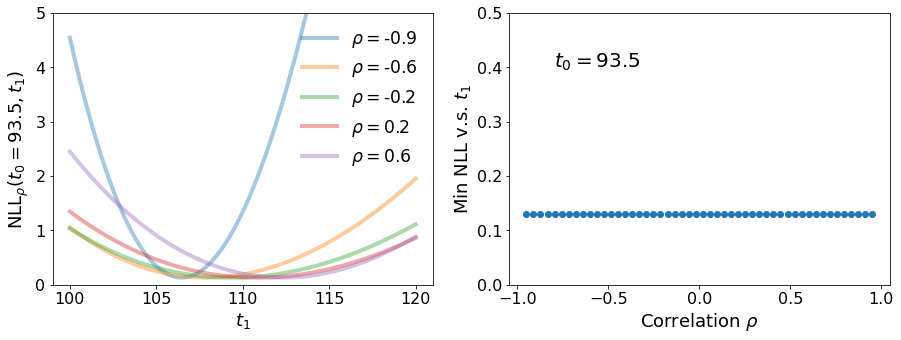

In [124]:
# Preparing plots
plt.figure(figsize=(15, 5))

# Comparing LLH(t0 fixed, t1, rho1) vs t1 and LLH(t0 fixed, t1, rho2) vs t1
rs  = np.linspace(-0.95, 0.95, 50)
t1s = np.linspace(100, 120, 500)
t0  = 93.5

# Loop over correlation coefficient
plt.subplot(1, 2, 1)
nllmin = []
for i, r in enumerate(rs):
    
    # Create the model
    m = unf.model(Ds, Rs, corrMatrix(r))fixed
    nlls = []
    
    # Loop over t1 values
    for t1 in t1s:
        nlls.append(m.NLL([[t0], [t1]]))
    
    # Plot NLL(t1) for this rho value
    if i%10 == 0:
        plt.plot(t1s, nlls, alpha=0.4, linewidth=4, label='$\\rho=$' + '{:.1f}'.format(r))

    # Get the mininum NLL value
    nllmin.append(min(nlls))
    
# Plot cosmetics
plt.ylim(0, 5)
plt.xlabel('$t_1$')
plt.ylabel('NLL$_{\\rho}(t_0=93.5, t_1)$')
plt.legend()

# Plotting the minium
plt.subplot(1, 2, 2)
plt.plot(rs, nllmin, 'o')
plt.ylim(0, 0.5)
plt.xlabel('Correlation $\\rho$')
plt.ylabel('Min NLL v.s. $t_1$')
plt.text(x=-0.8, y=0.4, s='$t_0=93.5$', fontdict={'fontsize':20});

## Analytical computation of NLL and comparison with `umodel` result

Writing $x_i \equiv (d_i - t_i) / \sigma_i$, the negative log likelihood can be easily expressed:

$$
\text{NLL}(x_0, x_1, \rho) \; = \; \frac{1}{1-\rho^2} \; \left( \, x_0^2 \,-\, 2\, \rho \, x_0 x_1 \,+\, x_1^2 \, \right)
$$

With this formula, it's clear that the NLL can be minimized for any fixed value of $x_0 = \alpha$ for 
$$
\hat{x}_1(\alpha, \rho) = \rho \alpha
$$

This form is obtained by computing $\Delta$ of the following quadratic form$f(x) = x^2 - 2\rho\alpha x + \alpha^2
$ leading to $\Delta = 4\alpha^2(\rho^2-1)$, which is negative for $\rho<1$. We can then consider a new function $\tilde{f}(x) \equiv f(x) - f_{\text{min}}$ where $f_{\text{min}}$ is chosen to obtain $\tilde{\Delta}=0$. In this case the minimum is obtained for $-b/2a$ when $f(x) = ax^2 + bx + c$, corresponding the $\hat{x}_1$ equation.

$$
\tilde{\Delta} = 4\alpha^2(\rho^2-1) + 4f_{\text{min}} ~ \to ~ f_{\text{min}} = \alpha^2 (1-\rho^2)
$$

The final profiled NLL is then independ from $\rho$: $\text{NLL}_{\text{min}[x_1]} = x_0^ 2$



In [217]:
def f(x0, x1, rho):
    '''Reduce NLL at 2D'''
    return 1/(1-rho**2) * (x0**2 - 2*rho*x0*x1 + x1**2)


def fmin(alpha, rho):
    '''Minium of Reduce NLL'''
    return alpha**2


def x1hat(alpha, rho):
    '''x1 values which minimize NLL(x0=alpha, x1)'''
    return rho * alpha 


def aNLL(t0, t1, rho):
    '''
    Return NLL given by the analytical formula
    '''
    d0, d1 = 5, 5
    x0 = (d0 - t0) / np.sqrt(t0)
    x1 = (d1 - t1) / np.sqrt(t1)
    return f(x0, x1, rho)


def aT1hat(t0, rho):
    '''
    Return t1 minimzing NLL(t0, rho) given by the analytical formula
    '''
    d0 = 5
    x0 = (d0 - t0) / np.sqrt(t0)
    return x1hat(x0, rho)


def afmin(t0, rho):
    '''
    Return minimzed NLL(t0, rho) vs t1 given by the analytical formula
    '''
    d0 = 5
    x0 = (d0 - t0) / np.sqrt(t0)
    return fmin(x0, rho)


def mNLL(t0, t1, rho):
    '''
    Return NLL given by the umodel package
    '''
    d0 = np.array([5])
    d1 = np.array([5])
    m = unf.model([d0, d1], Rs, corrMatrix(rho))
    return m.NLL([[t0], [t1]])


def mProfiledNLL(rho):
    '''
    Return (t0s, nlls) given by the umodel package
    '''
    d0 = np.array([5])
    d1 = np.array([5])
    m = unf.model([d0, d1], Rs, corrMatrix(rho))
    return m.profilePOI(0, 3, 7.5, 100)

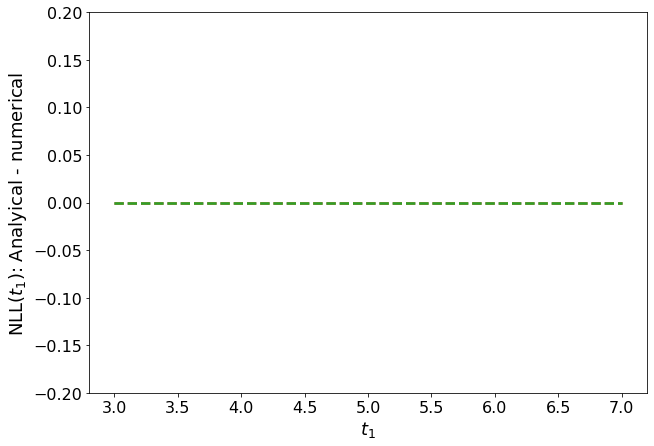

In [218]:
# Compare analytical - numerical: NLL(t0 fixe, t1, rho)
t0s = [5]
t1s = np.linspace(3, 7, 100)
for r in [-0.8, 0, 0.8]:
    for t0, ls in zip(t0s, ['--', ':', '-.']):
        nllsa = np.array([aNLL(t0, t1, r) for t1 in t1s])
        nllsm = np.array([mNLL(t0, t1, r) for t1 in t1s])
        plt.plot(x1s, nllsm - nllsa, linestyle=ls)

plt.xlabel('$t_1$')
plt.ylabel('NLL$(t_1)$: Analyical - numerical')
plt.ylim(-0.2, 0.2);

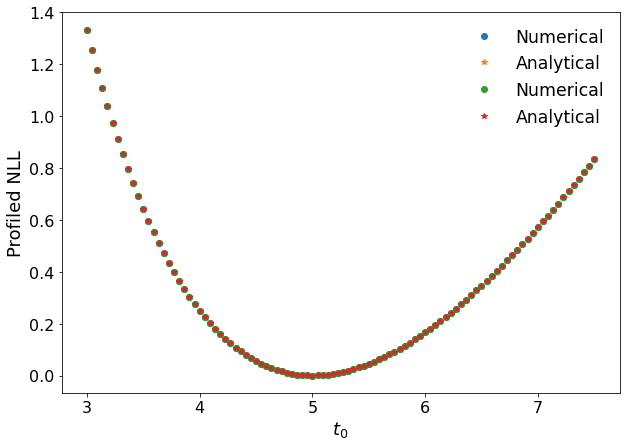

In [219]:
# Compare analytical - numerical: min[NLL(t0 fixe, t1, rho)] vs. t0
for r in [0.,  0.5]:
    t0s, nllsm = mProfiledNLL(r)
    nllsa = [afmin(t0, r) for t0 in t0s]
    plt.plot(t0s, nllsm, 'o', label='Numerical')
    plt.plot(t0s, nllsa, '*', label='Analytical')
    
plt.xlabel('$t_0$')
plt.ylabel('Profiled NLL')
plt.legend();